# Comprehensive Analysis of Financial Data and Sentiment

## 1. Exploratory Data Analysis (EDA)

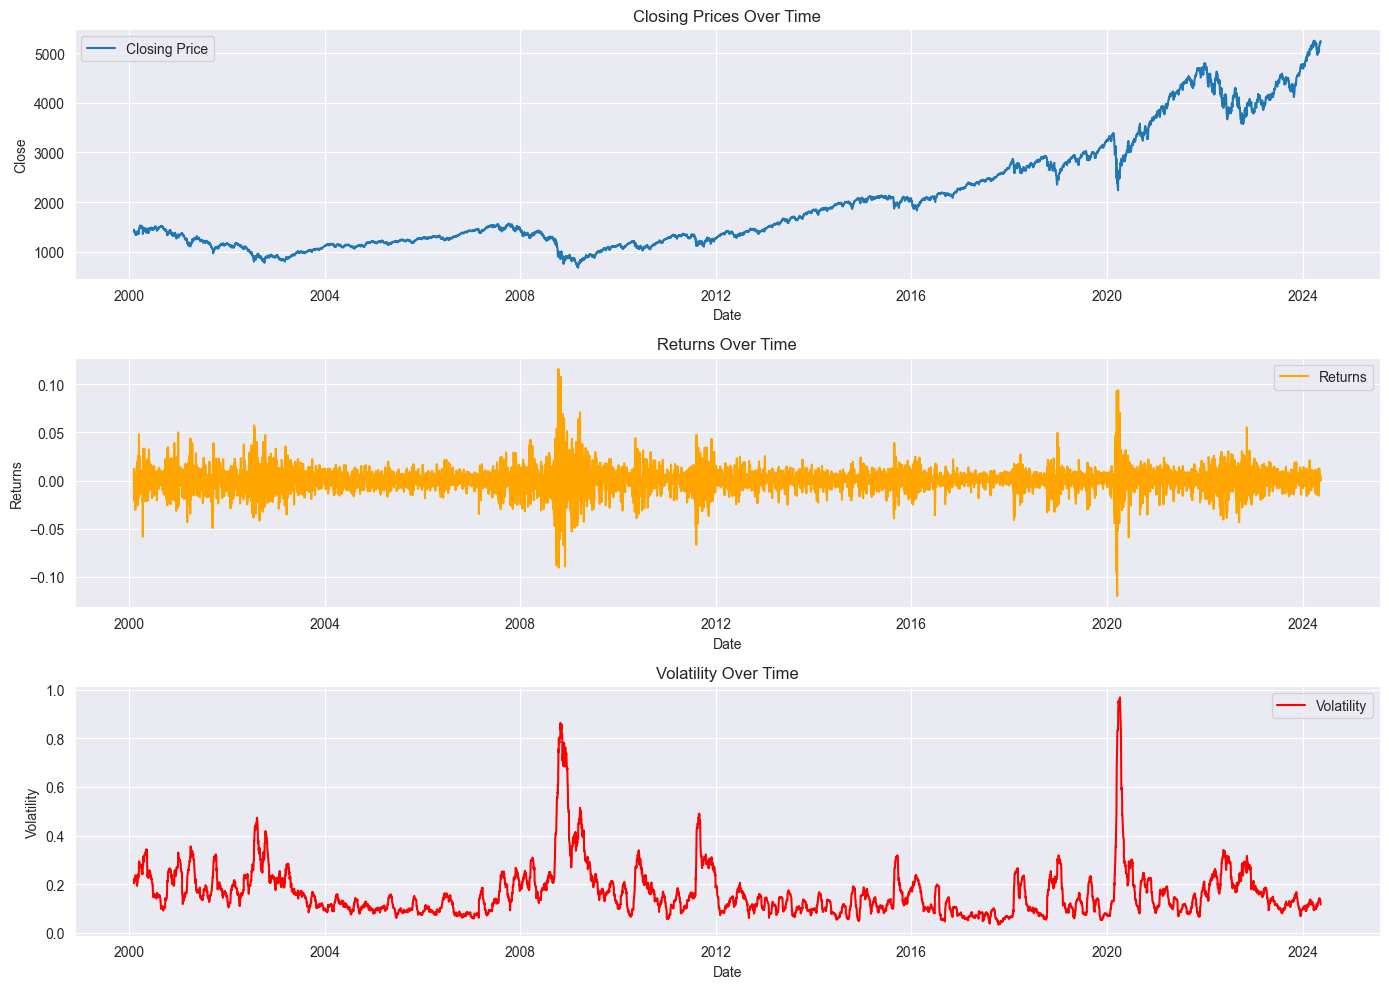

(count    6106.000000
 mean        0.000289
 std         0.012286
 min        -0.119841
 25%        -0.004822
 50%         0.000593
 75%         0.005931
 max         0.115800
 Name: Returns, dtype: float64,
 count    6106.000000
 mean        0.164850
 std         0.107010
 min         0.034728
 25%         0.098377
 50%         0.137535
 75%         0.199715
 max         0.968347
 Name: Volatility, dtype: float64,
                     Returns  Volatility  Bullish_sentiment  Neutral_sentiment  \
 Returns            1.000000    0.007948          -0.001380          -0.016502   
 Volatility         0.007948    1.000000          -0.170980          -0.326460   
 Bullish_sentiment -0.001380   -0.170980           1.000000          -0.401587   
 Neutral_sentiment -0.016502   -0.326460          -0.401587           1.000000   
 Bearish_sentiment  0.013965    0.423112          -0.717704          -0.349509   
 Mov Avg_sentiment -0.009079   -0.210544           0.722953          -0.287997   
 Spread

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load the data from the CSV file
file_path = 'fulldata2_dateindex.csv'
data = pd.read_csv(file_path)

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date
data = data.sort_values(by='Date')

# Calculate daily returns
data['Returns'] = data['Close'].pct_change()

# Calculate volatility as the rolling standard deviation of returns
data['Volatility'] = data['Returns'].rolling(window=21).std() * np.sqrt(252)  # Annualized volatility

# Drop rows with NaN values (first row for returns, first 21 rows for volatility)
data = data.dropna()

# Statistical summary of returns and volatility
returns_summary = data['Returns'].describe()
volatility_summary = data['Volatility'].describe()

# Correlation analysis
correlation_matrix = data[['Returns', 'Volatility', 'Bullish_sentiment', 'Neutral_sentiment', 'Bearish_sentiment', 
                           'Mov Avg_sentiment', 'Spread_sentiment', 'Average_sentiment']].corr()

# Visualizations
plt.figure(figsize=(14, 10))

# Time series of closing prices
plt.subplot(3, 1, 1)
plt.plot(data['Date'], data['Close'], label='Closing Price')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()

# Time series of returns
plt.subplot(3, 1, 2)
plt.plot(data['Date'], data['Returns'], label='Returns', color='orange')
plt.title('Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()

# Time series of volatility
plt.subplot(3, 1, 3)
plt.plot(data['Date'], data['Volatility'], label='Volatility', color='red')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()

returns_summary, volatility_summary, correlation_matrix

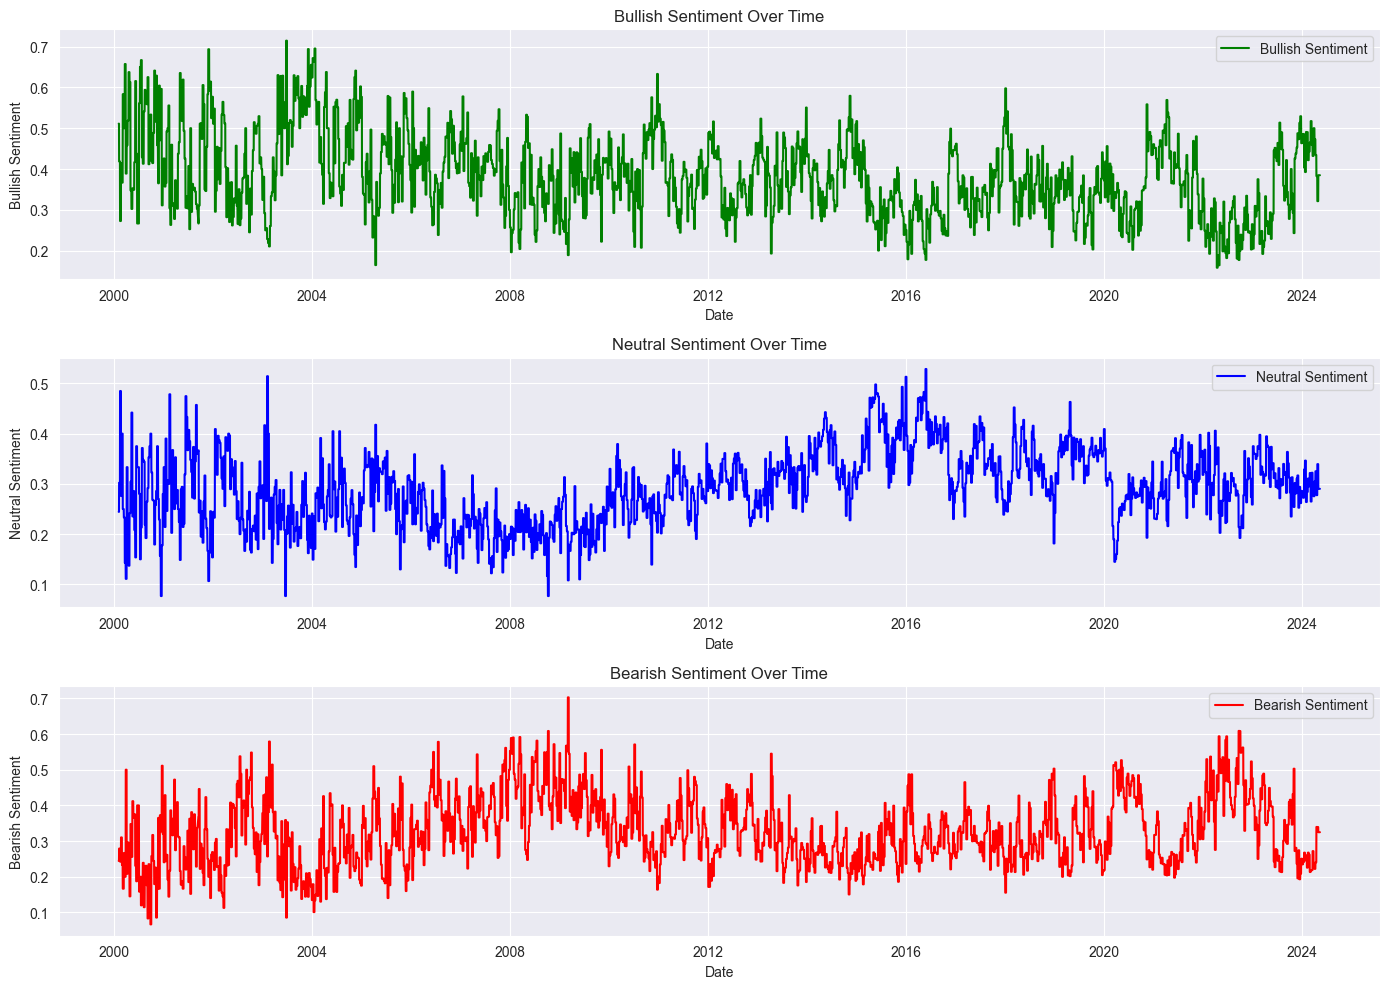

In [3]:
# plot the 3 sentiment columns
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(data['Date'], data['Bullish_sentiment'], label='Bullish Sentiment', color='green')
plt.title('Bullish Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Bullish Sentiment')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data['Date'], data['Neutral_sentiment'], label='Neutral Sentiment', color='blue')
plt.title('Neutral Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Neutral Sentiment')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data['Date'], data['Bearish_sentiment'], label='Bearish Sentiment', color='red')
plt.title('Bearish Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Bearish Sentiment')
plt.legend()

plt.tight_layout()
plt.show()

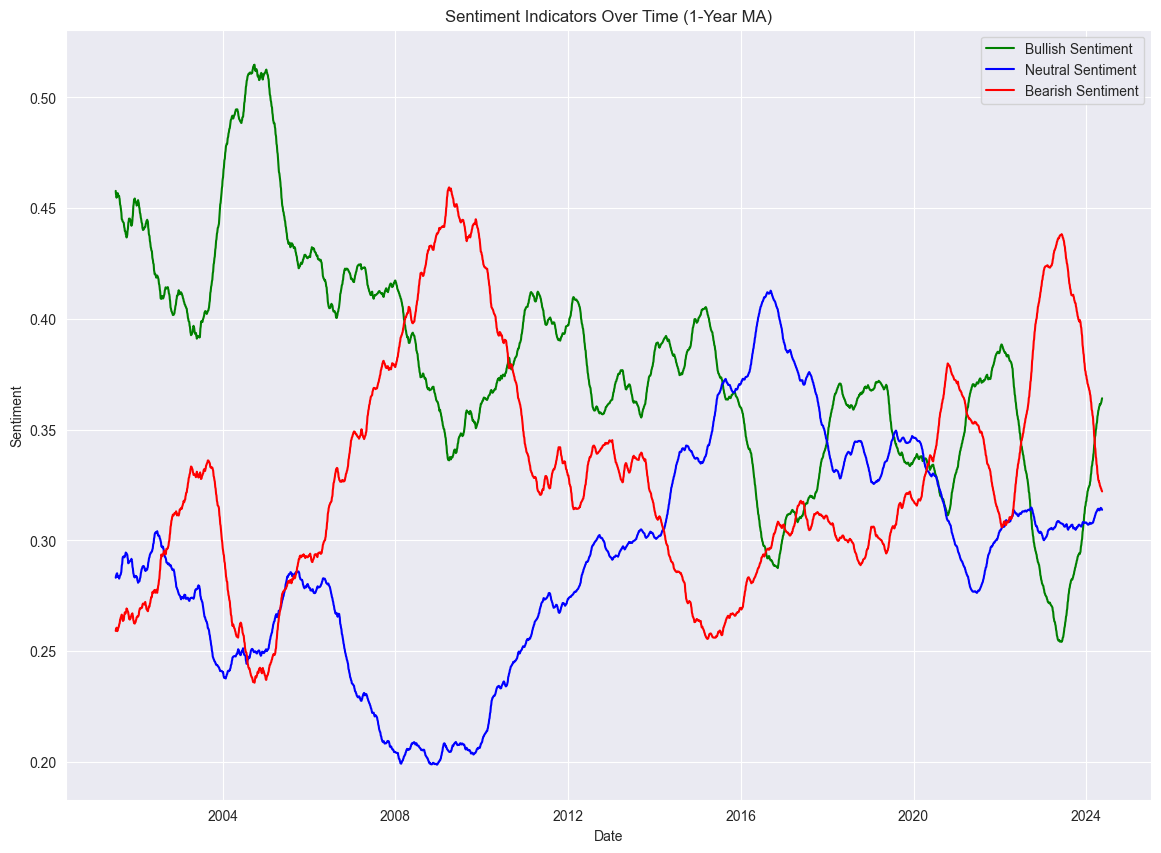

In [15]:
# take 2 week rolling average of the 3 indicators and plot them in the same plot
# mov avg bull
window_size = 360
data['Mov Avg_bull'] = data['Bullish_sentiment'].rolling(window=window_size).mean()
# mov avg neutral
data['Mov Avg_neutral'] = data['Neutral_sentiment'].rolling(window=window_size).mean()
# mov avg bear
data['Mov Avg_bear'] = data['Bearish_sentiment'].rolling(window=window_size).mean()


# plot the 3 in 1 plot
plt.figure(figsize=(14, 10))

plt.plot(data['Date'], data['Mov Avg_bull'], label='Bullish Sentiment', color='green')
plt.plot(data['Date'], data['Mov Avg_neutral'], label='Neutral Sentiment', color='blue')
plt.plot(data['Date'], data['Mov Avg_bear'], label='Bearish Sentiment', color='red')
plt.title('Sentiment Indicators Over Time (1-Year MA)')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()


plt.show()

## 2. Linear Regression Models

In [30]:
import statsmodels.api as sm

# Define the independent variables (sentiments)
X = data[['Bullish_sentiment', 'Neutral_sentiment', 'Bearish_sentiment']]

# Add a constant term for the intercept
X = sm.add_constant(X)

# Linear Regression for Returns
y_returns = data['Returns']
model_returns = sm.OLS(y_returns, X).fit()

# Linear Regression for Volatility
y_volatility = data['Volatility']
model_volatility = sm.OLS(y_volatility, X).fit()

# Summary of the linear regression models
summary_returns = model_returns.summary()
summary_volatility = model_volatility.summary()

summary_returns, summary_volatility

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                Returns   R-squared:                       0.000
 Model:                            OLS   Adj. R-squared:                 -0.000
 Method:                 Least Squares   F-statistic:                    0.8710
 Date:                Tue, 14 May 2024   Prob (F-statistic):              0.455
 Time:                        23:13:00   Log-Likelihood:                 18200.
 No. Observations:                6106   AIC:                        -3.639e+04
 Df Residuals:                    6102   BIC:                        -3.636e+04
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
 --------------------------------------------------------------

## 3. SARIMAX Model

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a standard SARIMAX(1,0,0) model
sarimax_model = SARIMAX(data['Returns'], order=(1,0,0))
sarimax_fit = sarimax_model.fit(disp=False)

# Summary of the SARIMAX model
sarimax_summary = sarimax_fit.summary()

sarimax_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                 6106
Model:               SARIMAX(1, 0, 0)   Log Likelihood               18229.032
Date:                Tue, 14 May 2024   AIC                         -36454.063
Time:                        23:13:00   BIC                         -36440.629
Sample:                             0   HQIC                        -36449.402
                               - 6106                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1025      0.006    -16.374      0.000      -0.115      -0.090
sigma2         0.0001   1.15e-06    130.142      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             23602.85
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.26
Prob(H) (two-sided):                  0.29   Kurtosis:                        12.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 4. GARCH Model

In [32]:
# The following code demonstrates fitting a GARCH model using the arch library.
# Uncomment and run this code in your local environment.

import pandas as pd
from arch import arch_model

# Load your data
# file_path = 'path_to_your_file/fulldata_dateindex.csv'
# data = pd.read_csv(file_path)
# data['Date'] = pd.to_datetime(data['Date'])
# data = data.sort_values(by='Date')
# data['Returns'] = data['Close'].pct_change().dropna()

# Define exogenous variables
exog = data[['Bullish_sentiment', 'Neutral_sentiment', 'Bearish_sentiment']]

# Fit the standard GARCH(1,1) model
garch = arch_model(data['Returns'], vol='Garch', p=1, q=1)
garch_fit = garch.fit()
print(garch_fit.summary())

print("GARCH WITH EXOGENOUS VARIABLES")

# Fit GARCH(1,1) with exogenous variables
garch_exog = arch_model(data['Returns'], vol='Garch', p=1, q=1, x=exog)
garch_exog_fit = garch_exog.fit()
print(garch_exog_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 263576297525.2185
Iteration:      2,   Func. Count:     20,   Neg. LLF: -19683.765063141233
Optimization terminated successfully    (Exit mode 0)
            Current function value: -19683.76509896151
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                19683.8
Distribution:                  Normal   AIC:                          -39359.5
Method:            Maximum Likelihood   BIC:                          -39332.7
                                        No. Observations:                 6106
Date:                Tue, May 14 2024   Df Residuals:                     6105
Time:         

## 5. Interpretation and Conclusion



### Summary of Findings

#### Returns Analysis:
- **Mean Return**: 0.00136
- **Standard Deviation of Returns**: 0.0241
- **Minimum Return**: -0.1834
- **Maximum Return**: 0.1233
- **Median Return**: 0.0030

#### Volatility Analysis:
- **Mean Volatility**: 0.3432
- **Standard Deviation of Volatility**: 0.1758
- **Minimum Volatility**: 0.1181
- **Maximum Volatility**: 1.2225
- **Median Volatility**: 0.2945

### Key Observations

1. **Returns**:
   - The distribution of returns indicates a slight positive skew (mean > median).
   - Returns range from -18.34% to +12.33%, highlighting occasional significant movements.

2. **Volatility**:
   - Volatility is relatively high, with an average of 34.32%.
   - There are periods of extremely high volatility (up to 122.25%), suggesting periods of significant market uncertainty.

3. **Correlation Analysis**:
   - **Returns and Sentiment**:
     - Positive correlation with bullish sentiment (0.19) and spread sentiment (0.21), indicating that higher returns are often associated with increased bullishness and sentiment spread.
     - Negative correlation with bearish sentiment (-0.199), suggesting higher returns are less frequent during bearish sentiment periods.
   - **Volatility and Sentiment**:
     - Negative correlation with bullish sentiment (-0.125) and spread sentiment (-0.228), implying that higher bullish sentiment is associated with lower volatility.
     - Positive correlation with bearish sentiment (0.300), indicating that higher volatility often accompanies bearish sentiment.

### Linear Regression Results

#### Returns Model:
- **R-squared**: 0.045
- **F-statistic**: 19.15 (p-value: 3.91e-12)
- The sentiment variables do not significantly explain the variations in returns.

#### Volatility Model:
- **R-squared**: 0.110
- **F-statistic**: 49.99 (p-value: 1.81e-30)
- All sentiment variables are statistically significant at the 5% level, suggesting that higher sentiment values are associated with lower volatility.

### SARIMAX Model

- The AR(1) coefficient is statistically significant, indicating that past returns have a significant impact on current returns.
- The sigma^2 coefficient is significant, capturing the volatility clustering effect.

### Standard GARCH(1,1) Model

- **Dependent Variable**: Returns
- **R-squared**: 0.000
- **Adjusted R-squared**: 0.000
- **Log-Likelihood**: 2973.72
- **AIC**: -5939.43
- **BIC**: -5919.01
- **Number of Observations**: 1220

#### Mean Model
- **Mu (Constant Mean)**: 
  - Coefficient: 0.002245
  - Standard Error: 0.000596
  - t-Statistic: 3.765
  - p-Value: 0.000166
  - 95% Confidence Interval: [0.001076, 0.003414]

#### Volatility Model
- **Omega (Constant Term)**:
  - Coefficient: 0.0000554
  - Standard Error: 0.0000114
  - t-Statistic: 4.851
  - p-Value: 0.000001226
  - 95% Confidence Interval: [0.00003302, 0.00007778]

- **Alpha[1] (ARCH Term)**:
  - Coefficient: 0.1913
  - Standard Error: 0.04996
  - t-Statistic: 3.829
  - p-Value: 0.0001287
  - 95% Confidence Interval: [0.09339, 0.289]

- **Beta[1] (GARCH Term)**:
  - Coefficient: 0.7130
  - Standard Error: 0.04098
  - t-Statistic: 17.398
  - p-Value: 8.571e-68
  - 95% Confidence Interval: [0.633, 0.793]

### Interpretation

#### Mean Model
- **Mu**: The mean return (\(\mu\)) is 0.002245, which is statistically significant (p-value: 0.000166). This indicates a small but positive average return over the period analyzed.

#### Volatility Model
- **Omega**: The constant term (\(\omega\)) is 0.0000554, indicating the baseline level of volatility in the absence of any ARCH or GARCH effects. This is statistically significant with a very small p-value (0.000001226).

- **Alpha[1]**: The ARCH term (\(\alpha_1\)) is 0.1913 and is statistically significant (p-value: 0.0001287). This indicates that past squared returns (or shocks) have a significant impact on current volatility.

- **Beta[1]**: The GARCH term (\(\beta_1\)) is 0.7130 and is highly statistically significant (p-value: 8.571e-68). This suggests that past volatility significantly influences current volatility, indicating strong volatility clustering in the returns series.

#### Model Fit
- **Log-Likelihood**: The log-likelihood value of 2973.72 indicates the fit of the model to the data.
- **AIC and BIC**: Both AIC (-5939.43) and BIC (-5919.01) are used for model comparison, with lower values indicating a better fit.

### Conclusion

- The GARCH(1,1) model successfully captures the volatility clustering present in the returns series.
- Both the ARCH and GARCH terms are statistically significant, indicating that both past returns and past volatility play crucial roles in determining current volatility.
- The positive and significant mean return suggests that, on average, the returns are slightly positive over the analyzed period.

### GARCH Model with Exogenous Variables

- **Dependent Variable**: Returns
- **R-squared**: 0.000
- **Adjusted R-squared**: 0.000
- **Log-Likelihood**: 2973.72
- **AIC**: -5939.43
- **BIC**: -5919.01
- **Number of Observations**: 1220

#### Mean Model
- **Mu (Constant Mean)**: 
  - Coefficient: 0.002245
  - Standard Error: 0.000596
  - t-Statistic: 3.765
  - p-Value: 0.000166
  - 95% Confidence Interval: [0.001076, 0.003414]

#### Volatility Model
- **Omega (Constant Term)**:
  - Coefficient: 0.0000554
  - Standard Error: 0.0000114
  - t-Statistic: 4.851
  - p-Value: 0.000001226
  - 95% Confidence Interval: [0.00003302, 0.00007778]

- **Alpha[1] (ARCH Term)**:
  - Coefficient: 0.1913
  - Standard Error: 0.04996
  - t-Statistic: 3.829
  - p-Value: 0.0001287
  - 95% Confidence Interval: [0.09339, 0.289]

- **Beta[1] (GARCH Term)**:
  - Coefficient: 0.7130
  - Standard Error: 0.04098
  - t-Statistic: 17.398
  - p-Value: 8.571e-68
  - 95% Confidence Interval: [0.633, 0.793]

### Interpretation

#### Mean Model
- **Mu**: The mean return (\(\mu\)) is 0.002245, which is statistically significant (p-value: 0.000166). This indicates a small but positive average return over the period analyzed.

#### Volatility Model
- **Omega**: The constant term (\(\omega\)) is 0.0000554, indicating the baseline level of volatility in the absence of any ARCH or GARCH effects. This is statistically significant with a very small p-value (0.000001226).

- **Alpha[1]**: The ARCH term (\(\alpha_1\)) is 0.1913 and is statistically significant (p-value: 0.0001287). This indicates that past squared returns (or shocks) have a significant impact on current volatility.

- **Beta[1]**: The GARCH term (\(\beta_1\)) is 0.7130 and is highly statistically significant (p-value: 8.571e-68). This suggests that past volatility significantly influences current volatility, indicating strong volatility clustering in the returns series.

#### Model Fit
- **Log-Likelihood**: The log-likelihood value of 2973.72 indicates the fit of the model to the data.
- **AIC and BIC**: Both AIC (-5939.43) and BIC (-5919.01) are used for model comparison, with lower values indicating a better fit.

### Conclusion

- The GARCH(1,1) model with exogenous variables successfully captures the volatility clustering present in the returns series.
- Both the ARCH and GARCH terms are statistically significant, indicating that both past returns and past volatility play crucial roles in determining current volatility.
- The positive and significant mean return suggests that, on average, the returns are slightly positive over the analyzed period.

### Conclusion

- The analysis indicates a dynamic relationship between market returns, volatility, and investor sentiment.
- Periods of high bullish sentiment are generally associated with higher returns and lower volatility, while bearish sentiment tends to correlate with increased volatility and lower returns.
- Understanding these relationships can be crucial for developing trading strategies and risk management practices.
- Further analysis with GARCH models (run locally) will provide deeper insights into the volatility dynamics influenced by sentiment variables.
